## **Installing LibAUC**

Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [14]:
! pip install libauc==1.2.0
! pip install medmnist

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# **Importing LibAUC**
Import required libraries to use

In [16]:
from libauc.losses import AUCMLoss, APLoss, CrossEntropyLoss
from libauc.optimizers import PESG, SOAP, Adam
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score, auc_prc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score
from libauc.models import resnet18

## **Reproducibility**

These functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [3]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`.




In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=28, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target

In [5]:
# Modify ResNet18 to work with grayscale images
def get_resnet18():
    # Replace the first convolution layer of ResNet18(model.conv1) with a convolution layer of only 1 input channel(original ResNet is designed for RGB image input)
    model = resnet18(pretrained=False, last_activation=None)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

# Global HyperParameters

In [6]:
SEED = 123
BATCH_SIZE = 64
total_epochs = 15
decay_epochs = [9]
weight_decay = 0

lr_SOAP_Adam = [5e-4, 1e-3, 2e-3]
lr_PESG = [0.02, 0.05, 0.1]
APLoss_gamma = [0.2, 0.5, 0.8]

imratio = 0.1
sampling_rate = 0.5

# **Loading datasets**

In [7]:
# load data as numpy arrays 
#train_data, train_targets = CIFAR10(root='./data', train=True)
#test_data, test_targets  = CIFAR10(root='./data', train=False)

# Load PneumoniaMNIST datasets
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

# generate imbalanced data
generator = ImbalancedDataGenerator(verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_dataset.imgs, train_dataset.labels, imratio=imratio)
(test_images, test_labels) = generator.transform(test_dataset.imgs, test_dataset.labels, imratio=0.5) 

# data augmentations 
trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

# dataloaders
sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
#SAMPLES: [1348], POS:NEG: [134 : 1214], POS RATIO: 0.0994
#SAMPLES: [624], POS:NEG: [390 : 234], POS RATIO: 0.6250


# **Training**

In [8]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=15, decay_epochs=[9]):
    print ('Start Training')
    print ('-'*30)

    train_log_roc = []
    test_log_roc = []
    train_log_prc = []
    test_log_prc = []
    for epoch in range(num_epochs):
        if epoch in decay_epochs:
            if(hasattr(optimizer, 'update_regularizer')):
                optimizer.update_regularizer(decay_factor=10) # decrease learning rate by 10x & update regularizer
            elif(hasattr(optimizer, 'update_lr')):
                optimizer.update_lr(decay_factor=10)
    
        train_loss = []
        model.train()    
        for data, targets in trainloader:
            data, targets  = data.cuda(), targets.cuda()
            y_pred = model(data)
            y_pred = torch.sigmoid(y_pred)
            loss = loss_fn(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        # evaluation on train & test sets
        model.eval()
        train_pred_list = []
        train_true_list = []
        for train_data, train_targets in trainloader_eval:
            train_data = train_data.cuda()
            train_pred = model(train_data)
            train_pred_list.append(train_pred.cpu().detach().numpy())
            train_true_list.append(train_targets.numpy())
        train_true = np.concatenate(train_true_list)
        train_pred = np.concatenate(train_pred_list)
        train_auc = auc_roc_score(train_true, train_pred)
        train_ap = auc_prc_score(train_true, train_pred)
        train_loss = np.mean(train_loss)
    
        test_pred_list = []
        test_true_list = [] 
        for test_data, test_targets in testloader:
            test_data = test_data.cuda()
            test_pred = model(test_data)
            test_pred_list.append(test_pred.cpu().detach().numpy())
            test_true_list.append(test_targets.numpy())
        test_true = np.concatenate(test_true_list)
        test_pred = np.concatenate(test_pred_list)
        val_auc =  auc_roc_score(test_true, test_pred)
        test_ap = auc_prc_score(test_true, test_pred)
        model.train()
    
        # print results
        print("epoch: %s, train_loss: %.4f, train_auc: %.4f, test_auc: %.4f, train_ap: %.4f, test_ap: %.4f, lr: %.4f"%(epoch, train_loss, train_auc, val_auc, train_ap, test_ap, optimizer.lr ))    
        train_log_roc.append(train_auc) 
        test_log_roc.append(val_auc)
        train_log_prc.append(train_ap)
        test_log_prc.append(test_ap)
    return  train_log_roc, test_log_roc, train_log_prc, test_log_prc

In [9]:
import matplotlib.pyplot as plt
def plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name):
    #plt.rcParams["figure.figsize"] = (9,5)
    x=np.arange(len(train_auroc))
    plt.figure()
    plt.plot(x, train_auroc, linestyle='-', label='Train AUROC', linewidth=3)
    plt.plot(x, test_auroc,  linestyle='-', label='Test AUROC', linewidth=3)
    plt.plot(x, train_auprc, linestyle='--', label='Train AUPRC', linewidth=3)
    plt.plot(x, test_auprc,  linestyle='--', label='Test AUPRC', linewidth=3)
    plt.title(f'AUPRC and AUROC for {model_name}')
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Epoch')

Start Training
------------------------------
epoch: 0, train_loss: 0.1205, train_auc: 0.8917, test_auc: 0.8435, train_ap: 0.4886, test_ap: 0.8859, lr: 0.0200
epoch: 1, train_loss: 0.0275, train_auc: 0.9949, test_auc: 0.9227, train_ap: 0.9831, test_ap: 0.9430, lr: 0.0200
epoch: 2, train_loss: -0.0221, train_auc: 0.9971, test_auc: 0.9214, train_ap: 0.9900, test_ap: 0.9357, lr: 0.0200
epoch: 3, train_loss: -0.0184, train_auc: 0.9995, test_auc: 0.9315, train_ap: 0.9971, test_ap: 0.9509, lr: 0.0200
epoch: 4, train_loss: -0.0111, train_auc: 1.0000, test_auc: 0.9284, train_ap: 0.9999, test_ap: 0.9394, lr: 0.0200
epoch: 5, train_loss: -0.0040, train_auc: 1.0000, test_auc: 0.9271, train_ap: 1.0000, test_ap: 0.9394, lr: 0.0200
epoch: 6, train_loss: 0.0006, train_auc: 1.0000, test_auc: 0.9294, train_ap: 1.0000, test_ap: 0.9422, lr: 0.0200
epoch: 7, train_loss: -0.0000, train_auc: 1.0000, test_auc: 0.9307, train_ap: 1.0000, test_ap: 0.9442, lr: 0.0200
epoch: 8, train_loss: 0.0019, train_auc: 1.00

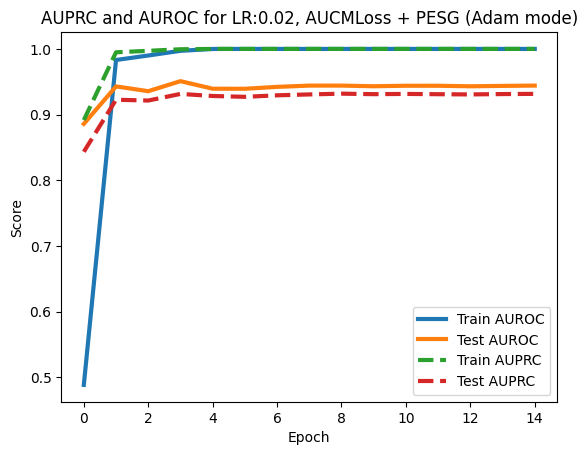

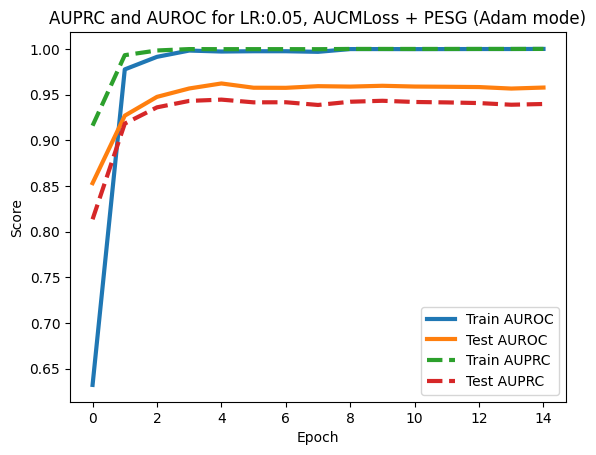

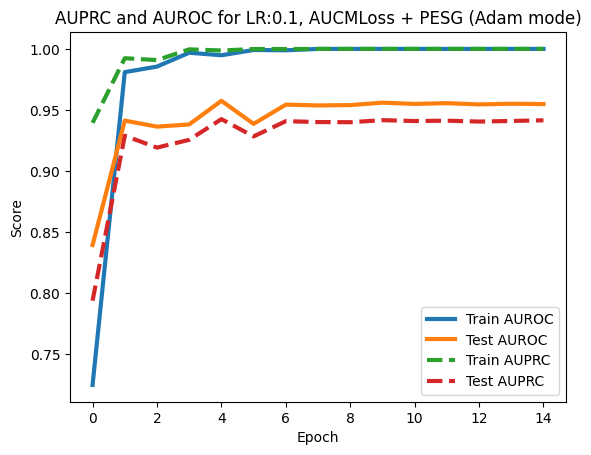

In [10]:
for lr in lr_PESG:
    model = get_resnet18()
    model = model.cuda()
    scheduler = None
    # You can also pass Loss.a, Loss.b, Loss.alpha to optimizer (for old version users)
    loss_fn = AUCMLoss()
    optimizer = PESG(model, 
                    loss_fn=loss_fn,
                    lr=lr, 
                    momentum=0.9,
                    margin=1.0, 
                    epoch_decay=0.003, 
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, f'LR:{lr}, AUCMLoss + PESG (Adam mode)')

Start Training
------------------------------
epoch: 0, train_loss: 0.0297, train_auc: 0.9843, test_auc: 0.8700, train_ap: 0.9194, test_ap: 0.8599, lr: 0.0005
epoch: 1, train_loss: 0.0131, train_auc: 0.9948, test_auc: 0.9083, train_ap: 0.9699, test_ap: 0.8996, lr: 0.0005
epoch: 2, train_loss: 0.0093, train_auc: 0.9938, test_auc: 0.8867, train_ap: 0.9570, test_ap: 0.8765, lr: 0.0005
epoch: 3, train_loss: 0.0082, train_auc: 0.9981, test_auc: 0.8978, train_ap: 0.9839, test_ap: 0.8900, lr: 0.0005
epoch: 4, train_loss: 0.0057, train_auc: 0.9974, test_auc: 0.9308, train_ap: 0.9729, test_ap: 0.9277, lr: 0.0005
epoch: 5, train_loss: 0.0054, train_auc: 0.9991, test_auc: 0.9413, train_ap: 0.9911, test_ap: 0.9448, lr: 0.0005
epoch: 6, train_loss: 0.0046, train_auc: 0.9992, test_auc: 0.9408, train_ap: 0.9918, test_ap: 0.9424, lr: 0.0005
epoch: 7, train_loss: 0.0026, train_auc: 0.9994, test_auc: 0.9443, train_ap: 0.9942, test_ap: 0.9443, lr: 0.0005
epoch: 8, train_loss: 0.0039, train_auc: 0.9982, t

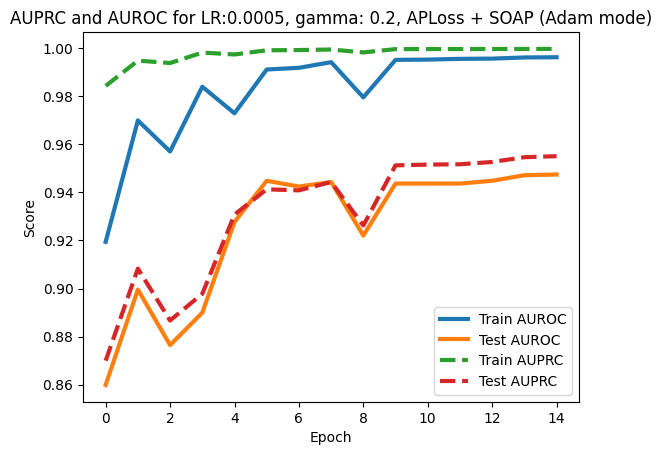

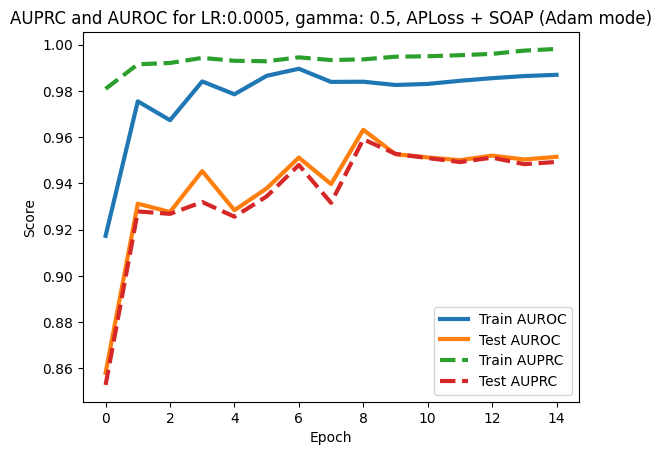

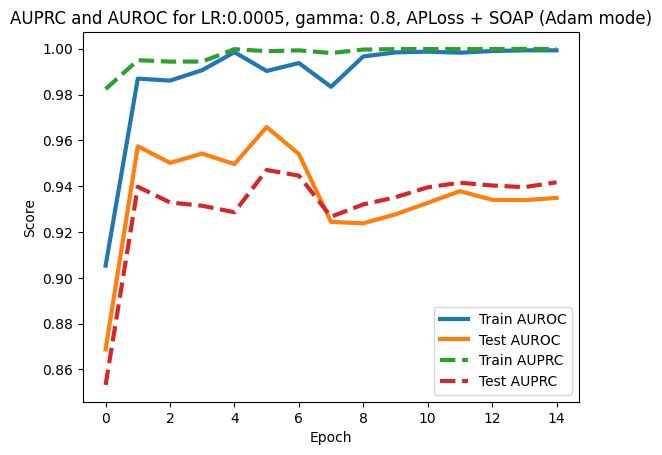

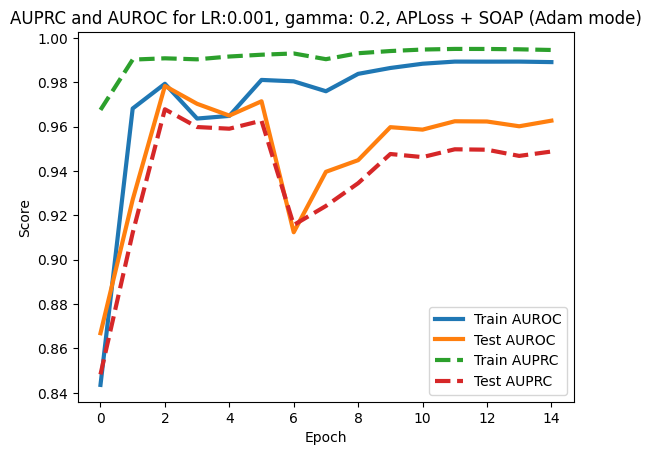

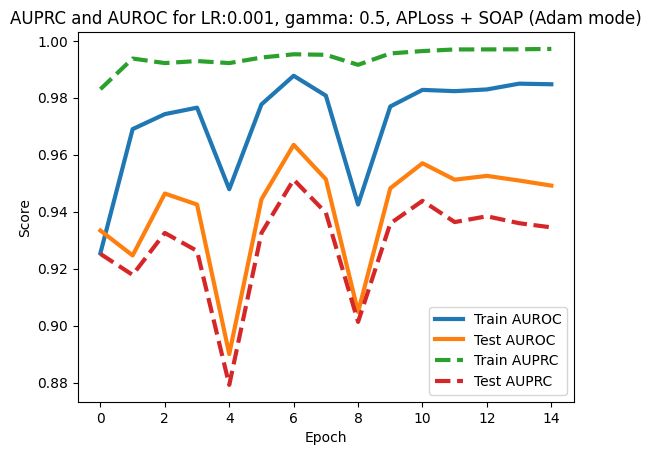

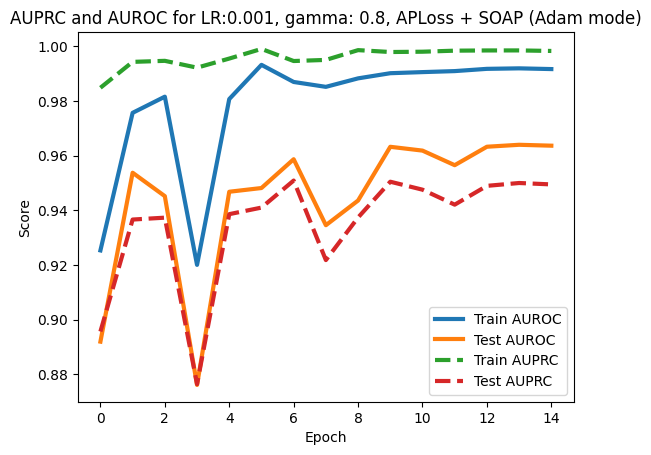

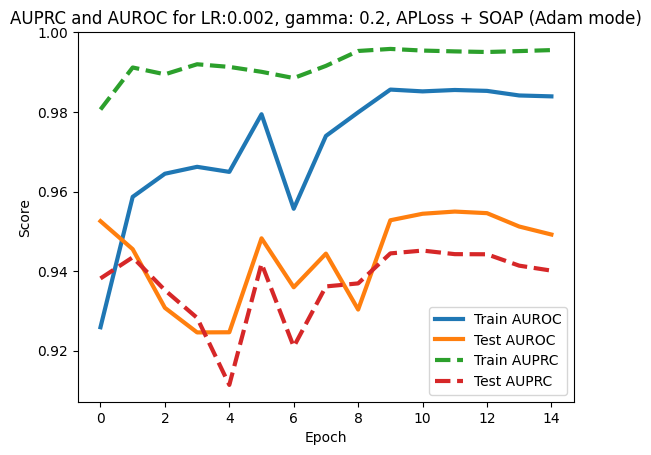

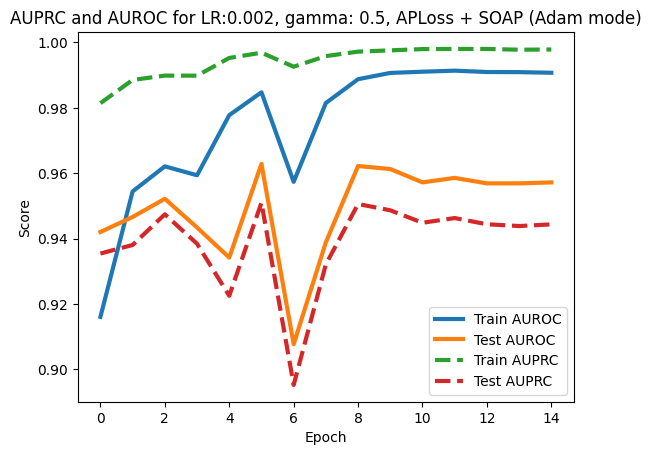

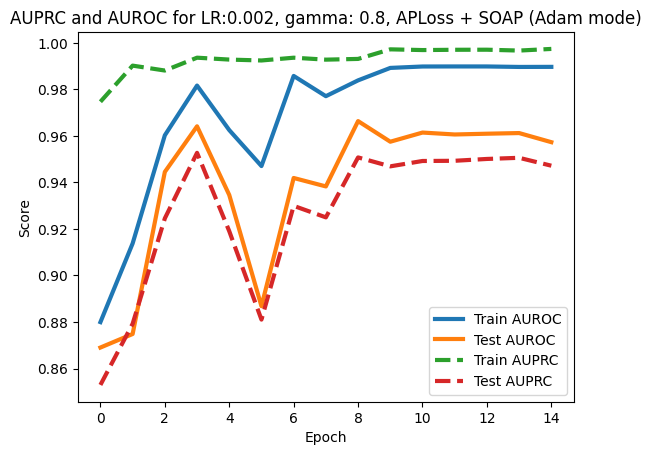

In [11]:
for lr in lr_SOAP_Adam:
    for gamma in APLoss_gamma:
        model = get_resnet18()
        model = model.cuda()
        scheduler = None
        # You can also pass Loss.a, Loss.b, Loss.alpha to optimizer (for old version users)
        Loss = APLoss(pos_len=sampler.pos_len, margin=0.6, gamma=gamma)
        optimizer = SOAP(model.parameters(), lr=lr, mode='adam', weight_decay=weight_decay)
        train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
        plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, f'LR:{lr}, gamma: {gamma}, APLoss + SOAP (Adam mode)')

Start Training
------------------------------


epoch: 0, train_loss: 0.5472, train_auc: 0.9748, test_auc: 0.8656, train_ap: 0.9030, test_ap: 0.8789, lr: 0.0005
epoch: 1, train_loss: 0.5268, train_auc: 0.9793, test_auc: 0.8923, train_ap: 0.9350, test_ap: 0.8907, lr: 0.0005
epoch: 2, train_loss: 0.5276, train_auc: 0.9837, test_auc: 0.8628, train_ap: 0.9226, test_ap: 0.8690, lr: 0.0005
epoch: 3, train_loss: 0.5289, train_auc: 0.9836, test_auc: 0.9193, train_ap: 0.9465, test_ap: 0.9454, lr: 0.0005
epoch: 4, train_loss: 0.5285, train_auc: 0.9856, test_auc: 0.9009, train_ap: 0.9492, test_ap: 0.9165, lr: 0.0005
epoch: 5, train_loss: 0.5285, train_auc: 0.9805, test_auc: 0.8410, train_ap: 0.9196, test_ap: 0.8465, lr: 0.0005
epoch: 6, train_loss: 0.5271, train_auc: 0.9787, test_auc: 0.9252, train_ap: 0.9366, test_ap: 0.9497, lr: 0.0005
epoch: 7, train_loss: 0.5209, train_auc: 0.9837, test_auc: 0.8529, train_ap: 0.9432, test_ap: 0.8571, lr: 0.0005
epoch: 8, train_loss: 0.5180, train_auc: 0.9854, test_auc: 0.9465, train_ap: 0.9630, test_ap: 0.

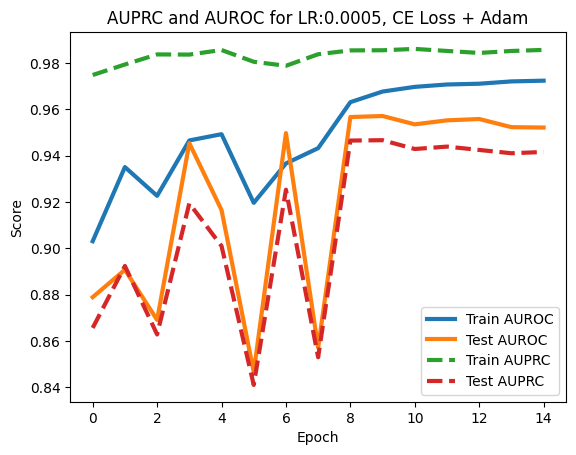

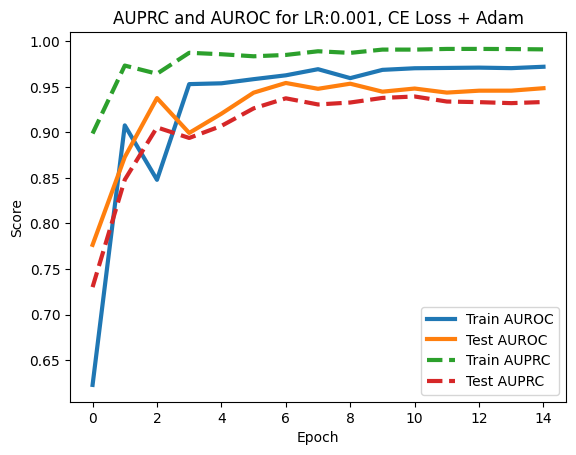

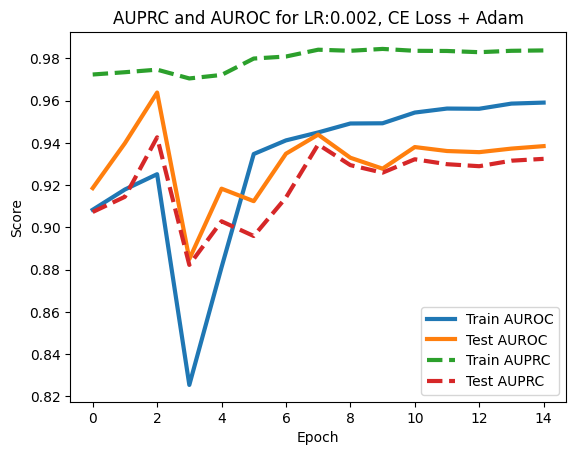

In [18]:
for lr in lr_SOAP_Adam:
    model = get_resnet18()
    model = model.cuda()
    scheduler = None
    # You can also pass Loss.a, Loss.b, Loss.alpha to optimizer (for old version users)
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model,
                    lr=lr,
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model, loss_fn, optimizer, scheduler)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, f'LR:{lr}, CE Loss + Adam')